In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23 00:00:00


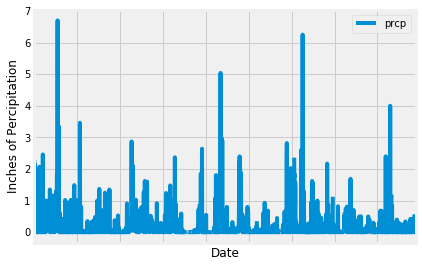

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
year_per = (session.query(Measurement.date).order_by(Measurement.date.desc()).first()).date
    

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(year_per, '%Y-%m-%d') - dt.timedelta(days=365)
print(last_year)


# Perform a query to retrieve the data and precipitation scores
percipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date> last_year).order_by(Measurement.date).all()

percipitation
# Save the query results as a Pandas DataFrame and set the index to the date column
percp = pd.DataFrame(percipitation)

# Sort the dataframe by date
percp.set_index('date')


# Use Pandas Plotting with Matplotlib to plot the data
percp.plot('date', 'prcp')
plt.ylabel("Inches of Percipitation")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.tick_params(labelbottom=False)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = (session.query(Station).group_by(Station.station).count())
print(f'There are {stations} stations')

There are 9 stations


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
top_station = (session.query(Measurement.station, func.count(Measurement.station))
          .group_by(Measurement.station)
          .order_by(func.count(Measurement.station).desc()).all())
top_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_active = top_station[0][0]

name_station = (session.query(Station.name).filter_by(station = station_active))

name_station = name_station[0][0]
name_station

high_temp = (session.query(Measurement.tobs).filter(Measurement.station == station_active).order_by(Measurement.station==station_active).order_by(Measurement.tobs.desc()).first())
high_temp = high_temp[0]
print(f'testing {high_temp}')

low_temp = (session.query(Measurement.tobs).filter(Measurement.station == station_active).order_by(Measurement.station== station_active).order_by(Measurement.tobs.asc()).first())
low_temp = low_temp[0]
print(f'testing {low_temp}')

average_temp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station==station_active))
average_temp = '{0:.3}'.format(average_temp[0][0])
average_temp

testing 85.0
testing 54.0


'71.7'

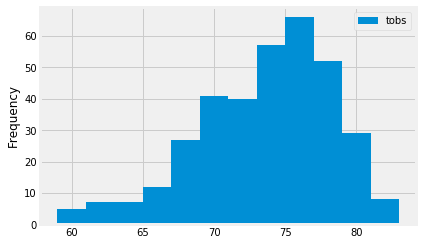

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_year).filter(Measurement.station == station_active).order_by(Measurement.date).all())
temp_data = pd.DataFrame(temp_year)

temp_data = temp_data.set_index('date')

temp_data = temp_data.sort_index(ascending = True)
temp_data.plot(kind='hist',bins= 12)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 2, 28)
end_date = dt.date(2017, 3, 5)
total_trip = '2017-02-28 to \n 2017-03-05'

one_year = dt.timedelta(days=365)
average_past_year = (calc_temps((start_date - one_year), (end_date - one_year)))
average_past_year

[(62.0, 69.65789473684211, 79.0)]

Text(0.5, 1.0, 'Trip Average Temp')

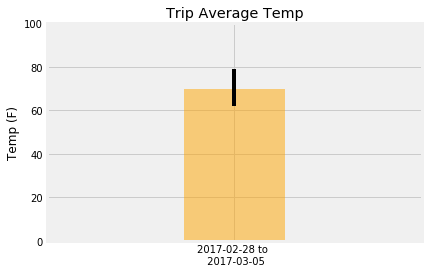

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min = average_past_year[0][0]
mid = average_past_year[0][1]
max = average_past_year[0][2]

top_error = max - mid
bot_error = mid - min

yerr = np.array([[bot_error], [top_error]])

error = max - min
y = mid
x = 0

plt.bar(total_trip, mid, yerr=yerr, color = 'orange', alpha =.5)
plt.xlim (-1.5,1.5)
plt.ylim (0,100)
plt.ylabel('Temp (F)')
plt.title('Trip Average Temp')


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

hawaii = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

rain_fall = (session.query(*hawaii)
             .filter(Station.station == Measurement.station)
             .filter(Measurement.date >= start_date)
             .filter(Measurement.date <= end_date)
             .group_by(Station.station)
             .order_by(func.sum(Measurement.prcp).desc())
             .all())
rain_fall = pd.DataFrame(np.array(rain_fall))

rain_fall = rain_fall.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})
rain_fall

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",4.720000000000001,21.45167,-157.84888999999998,32.9
1,USC00513117,"KANEOHE 838.1, HI US",4.45,21.4234,-157.8015,14.6
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.07,21.3331,-157.8025,152.4
3,USC00517948,"PEARL CITY, HI US",2.98,21.3934,-157.9751,11.9
4,USC00519397,"WAIKIKI 717.2, HI US",2.7399999999999998,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32,21.33556,-157.71139,19.5
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.1600000000000001,21.5213,-157.8374,7.0


## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


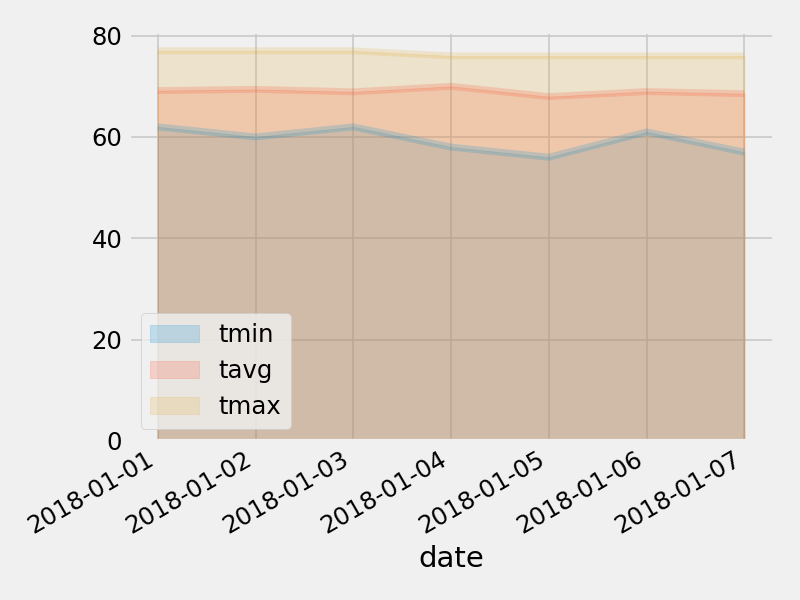

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
